In [205]:
# General SVM Class that will be a base for all the other SVM Implementations
import torch
import numpy as np

class SVM(object):
    def __init__(self):
        self.W = None
        random.seed(0)
        torch.manual_seed(0)

        
    def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-3, num_iters=100,
            batch_size=200, print_progress=False, exit_diff=0.0005):
        """
            Takes in the training data and labels as well as training parameters.
            Updates the weights using stochastic gradient descent

            Inputs:
            - X_train: A PyTorch tensor of shape (N, D) containing training data; there are N
            training samples each of dimension D.
            - y_train: A PyTorch tensor of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
            - learning_rate: (float) learning rate for optimization.
            - reg: (float) regularization strength. (ie. lambda)
            - num_iters: (integer) number of steps to take when optimizing
            - batch_size: (integer) number of training examples to use at each step.
            - print_progress: (boolean) If true, print progress during optimization.
            - exit_diff: (float) condition to stop the gradient descent algorithm if the
            change in loss is too low.

            Returns: A tuple of:
            - loss_all: A PyTorch tensor giving the values of the loss at each
                training iteration.
        """
        self.W, loss_history = self.train_linear_classifier(self.loss, self.W, X_train, y_train, learning_rate, reg, num_iters, batch_size, print_progress, exit_diff)
        
        return loss_history

    def sample_batch(self,X, y, N, batch_size):
        # randomly sample "batch_size" (Xi,yi) in (X,y)

        inx = torch.randint(0, N, [batch_size])

        X_batch = X[inx, :]
        y_batch = y[inx]

        return X_batch, y_batch

    def train_linear_classifier(self,loss_fun, W, X, y, learning_rate=1e-4, reg=1e-2, num_iters=1000,
            batch_size=200, print_progress=False):
        '''
        Output:
        - W:            A PyTorch tensor giving the weight of SVM predictor
        - loss_history: A PyTorch tensor giving the values of the loss at each training iteration.
        '''

        N, D = X.shape
        print('N',N, ' D', D)

        # initialize weight
        if W is None:
            # number of classes
            # C = torch.max(y)+1
            C = 1

            # W = torch.zeros([D, C], dtype=X.dtype, device=X.device)
            W = 1 * torch.randn(D, C, device=X.device, dtype=X.dtype)
            # W = torch.zeros(D, C, device=X.device, dtype=X.dtype)

        else:
            # C = W.shape[1]
            C = 1

        # Stochastic Gradient Descent
        loss_history = torch.zeros(num_iters, dtype=X.dtype, device=X.device)
        for it in range(num_iters):
            # sample batch
            X_batch, y_batch = self.sample_batch(X, y, N, batch_size)

            # compute loss and gradient
            loss, grad = loss_fun(W, X_batch, y_batch, reg)
            loss_history[it] = loss

            # update weight
            W = W - learning_rate*grad

            if print_progress and i % 100 == 0:
                print('iteration %d / %d: loss %f' % (i, num_iters, loss_history[i]))

        # return 
        return W, loss_history
        
    def predict(self, X):
        """
        Takes in the test data and outputs a prediction torch
        Inputs: 
        - X: A PyTorch tensor of shape (N, D) containing N data points and each point has dimension D.
        - self.W: A PyTorch tensor of shape (D, C) containing the weights
        Output:
        - y_pred: A PyTorch tensor of shape (N,) containing 0~(C-1) labels for the X
        """
        prob = torch.matmul(X,self.W) # (N, C)
        
        # y_pred = torch.argmax(prob, dim=1)
        y_pred = torch.sign(prob).reshape(-1)

        return y_pred
    
    # @abstractmethod
    # def loss(self, W, X_batch, y_batch, reg):
    #     """
    #     Compute the loss function and its derivative.
    #     Subclasses will override this.

    #     Inputs:
    #     - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
    #     - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
    #     data points; each point has dimension D.
    #     - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
    #     - reg: (float) regularization strength.

    #     Returns: A tuple containing:
    #     - loss as a single float

    #     - gradient with respect to self.W; an tensor of the same shape as W
    #     """
    #     raise NotImplementedError
    
class LinearSVM(SVM):
    def loss(self, W, X_batch, y_batch, reg = 1e-2):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
        - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - dW: gradient with respect to self.W; an tensor of the same shape as W
        """
        
        # Let autograd get us the gradient with respect to W
        W.requires_grad = True 
        
        '''
        # calculate the multiclass SVM loss
        N = X_batch.shape[0]
        scores = (X_batch.matmul(W)).t() # CxN matrix
        temp_index = torch.arange(N)
        correct_scores = scores[y_batch, temp_index]
        Margins = scores - correct_scores + torch.ones_like(scores, device = X_batch.device, dtype = X_batch.dtype)
        Margins[Margins<0] = 0 # Apply the max function

        loss = Margins.sum()/N - 1 # get the average loss and subtract 1 for the j=y_i case
        loss += 0.5 * reg * torch.sum(W * W)
        '''
        
        # Wei-Chun's method: 2-class SVM with y = {-1,1} converted to use torch functions
        # This assumes W is Dx1 
        N = X_batch.shape[0]
        y_pred = X_batch.matmul(W) # N-sized array
        
        # get svm loss term
        loss_array = 1.0 - y_batch * y_pred 
        
        # apply the max function when compared to 0
        loss_array[loss_array < 0.0] = 0.0 
        # print(loss_array[:10])
        
        # get the overall loss mean
        loss = torch.mean(loss_array) 
        
        # add regularization term
        loss += 0.5 * reg * torch.sum(W * W) 
        # print(loss)
        
        
        loss.backward()
        
        with torch.no_grad():
            dw = W.grad
        
        # stop the gradient calculations since we are done
        W.requires_grad = False

        return loss, dw
    
# search for hyperparameters:
def search_for_hyperparams():
    learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    regs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    max_acc = 0.0
    max_reg = 0.0
    max_lr = 0.0
    for reg in regs:
        for lr in learning_rates:
            LSVM = SVM()
            loss_history = LSVM.train(x_with_ones, y, reg=reg, num_iters=1000, learning_rate=lr, print_progress = False)
            y_pred = LSVM.predict(x_with_ones)
            acc = ((y==y_pred).sum()) / float(y.shape[0])
            if(acc > max_acc):
                max_acc = acc
                max_reg = reg
                max_lr = lr

            print("at reg = {} and lr = {} we get acc = {}" .format(reg, lr, acc))


    print("Max we get at: reg: {} and lr = {} we get acc = {}" .format(max_reg, max_lr, max_acc))
    

def apply_sklearn_svm(x_train, y_train, x_test):
    # Linear SVM on this dataset
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(x_train, y_train)
    y_pred = torch.tensor(svclassifier.predict(x_test))
    acc = ((y_train==y_pred).sum()) / float(y_train.shape[0])
    print(acc)

SyntaxError: invalid syntax (<ipython-input-1-9014a466bc9d>, line 16)

# Verifying with EECS545 HW3b

In [206]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import SVMClass

np.random.seed(0)

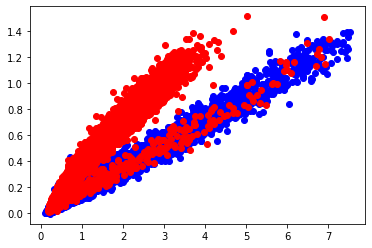

In [207]:
nuclear = sio.loadmat('Data/nuclear.mat')

x = torch.tensor(nuclear['x'])
y = torch.tensor(nuclear['y'], dtype = torch.long)

N = x.shape[1]

## reshape data
x = x.t()               # x \in (N,D)
y = y.reshape(N)        # y \in (N,)

# change the label into {0,1}
# y = (y+1)//2

# Preprocess: append 1s at the end of data vectors
ones_x = torch.ones((N,1))
x_with_ones = torch.cat((x,ones_x),axis=1)

negInd = y == -1
posInd = y == 1
plt.scatter(x[negInd, 0], x[negInd, 1], color='b')
plt.scatter(x[posInd, 0], x[posInd, 1], color='r')
plt.figure(1)
plt.show()

In [222]:
LSVM = LinearSVM()

loss_history = LSVM.train(x_with_ones, y, reg=1e-03, num_iters=1000, learning_rate=1e-05)

y_pred = LSVM.predict(x_with_ones)

print((y!=y_pred).sum())

N 20000  D 3
tensor(10000)


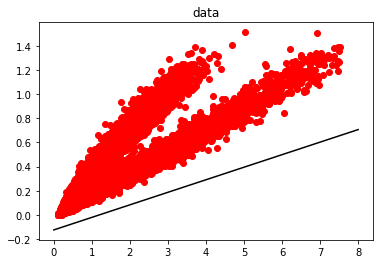

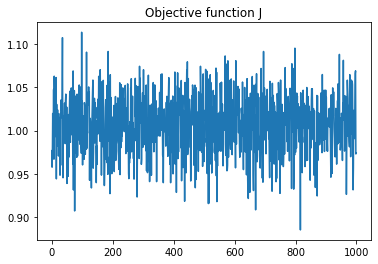

In [223]:
W = LSVM.W[:]

w1 = W[0]
w2 = W[1]
b = W[2]

x0_vals = torch.tensor(np.linspace(0, 8, 8)).reshape(1,-1)
y_vals = (-b - w1*x0_vals) / w2

plt.figure(1)
plt.plot(x0_vals[0,:], y_vals[0,:], color='black', label='Learned line')
plt.title('data')
# plt.show()

negInd = y_pred == -1
posInd = y_pred == 1
plt.scatter(x[negInd, 0], x[negInd, 1], color='b')
plt.scatter(x[posInd, 0], x[posInd, 1], color='r')
plt.show()

plt.figure(2)
plt.plot(loss_history.detach().numpy())
plt.title('Objective function J')
plt.show()

In [217]:
print(N)
print(posInd.sum())

print(loss_history[:10])
print(W)

print(negInd.shape)
print(y.shape)

20000
tensor(289)
tensor([1.6337, 1.8970, 1.8490, 1.9080, 1.8407, 1.8998, 1.8466, 1.8796, 1.7799,
        1.8141], dtype=torch.float64, grad_fn=<SliceBackward>)
tensor([[-2.0371],
        [-0.7773],
        [ 0.4517]], dtype=torch.float64)
torch.Size([20000])
torch.Size([20000])


In [164]:
torch.randn(3, 1, device=x.device, dtype=x.dtype)

tensor([[-1.0129],
        [-0.6007],
        [ 0.8640]], dtype=torch.float64)